In [3]:
getDefaultColors <- function (n = NULL, type = 1) 
{
  if (type == 1) {
    colors <- c("#cb7c77", "#68d359", "#6a7dc9", "#c9d73d", 
      "#c555cb", "#d7652d", "#7cd5c8", "#c49a3f", "#507d41", 
      "#5d8d9c", "#90353b", "#674c2a", "#1B9E77", "#c5383c", 
      "#0081d1", "#ffd900", "#502e71", "#c8b693", "#aed688", 
      "#f6a97a", "#c6a5cc", "#798234", "#6b42c8", "#cf4c8b", 
      "#666666", "#feb308", "#ff1a1a", "#1aff1a", "#1a1aff", 
      "#ffff1a")
  }
  else if (type == 2) {
    if (n <= 8) {
      colors <- c("#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3", 
        "#A6D854", "#FFD92F", "#E5C494", "#B3B3B3")
    }
    else if (n <= 14) {
      colors <- c("#437BFE", "#FEC643", "#43FE69", "#FE6943", 
        "#C643FE", "#43D9FE", "#B87A3D", "#679966", 
        "#993333", "#7F6699", "#E78AC3", "#333399", 
        "#A6D854", "#E5C494")
    }
    else if (n <= 20) {
      colors <- c("#87b3d4", "#d5492f", "#6bd155", "#683ec2", 
        "#c9d754", "#d04dc7", "#81d8ae", "#d34a76", 
        "#607d3a", "#6d76cb", "#ce9d3f", "#81357a", 
        "#d3c3a4", "#3c2f5a", "#b96f49", "#4e857e", 
        "#6e282c", "#d293c8", "#393a2a", "#997579")
    }
    else if (n <= 30) {
      colors <- c("#628bac", "#ceda3f", "#7e39c9", "#72d852", 
        "#d849cc", "#5e8f37", "#5956c8", "#cfa53f", 
        "#392766", "#c7da8b", "#8d378c", "#68d9a3", 
        "#dd3e34", "#8ed4d5", "#d84787", "#498770", 
        "#c581d3", "#d27333", "#6680cb", "#83662e", 
        "#cab7da", "#364627", "#d16263", "#2d384d", 
        "#e0b495", "#4b272a", "#919071", "#7b3860", 
        "#843028", "#bb7d91")
    }
    else {
      colors <- c("#982f29", "#5ddb53", "#8b35d6", "#a9e047", 
        "#4836be", "#e0dc33", "#d248d5", "#61a338", 
        "#9765e5", "#69df96", "#7f3095", "#d0d56a", 
        "#371c6b", "#cfa738", "#5066d1", "#e08930", 
        "#6a8bd3", "#da4f1e", "#83e6d6", "#df4341", 
        "#6ebad4", "#e34c75", "#50975f", "#d548a4", 
        "#badb97", "#b377cf", "#899140", "#564d8b", 
        "#ddb67f", "#292344", "#d0cdb8", "#421b28", 
        "#5eae99", "#a03259", "#406024", "#e598d7", 
        "#343b20", "#bbb5d9", "#975223", "#576e8b", 
        "#d97f5e", "#253e44", "#de959b", "#417265", 
        "#712b5b", "#8c6d30", "#a56c95", "#5f3121", 
        "#8f846e", "#8f5b5c")
    }
  }
  else if (type == 3) {
    colors <- c("#c14089", "#6f5553", "#E5C494", "#738f4c", 
      "#bb6240", "#66C2A5", "#2dfd29", "#0c0fdc")
  }
  if (!is.null(n)) {
    if (n <= length(colors)) {
      colors <- colors[1:n]
    }
    else {
      step <- 16777200%/%(n - length(colors)) - 2
      add.colors <- paste0("#", as.hexmode(seq(from = sample(1:step, 
        1), by = step, length.out = (n - length(colors)))))
      colors <- c(colors, add.colors)
    }
  }
  return(colors)
}


In [4]:
seurat_pipline <- function(obj,PCS = 10,resolution = 0.5,k.param = 20){
  require(dplyr)
  obj = NormalizeData(obj, normalization.method = "LogNormalize", scale.factor = 10000,verbose = FALSE)
  obj = FindVariableFeatures(obj,verbose = FALSE) 
  obj = ScaleData(obj,features = VariableFeatures(obj),verbose = FALSE,vars.to.regress = c("nCount_RNA", "nFeature_RNA"))
  obj = RunPCA(obj,features = VariableFeatures(obj),verbose = FALSE) %>%
    FindNeighbors(dims = 1:PCS,verbose = FALSE,k.param = k.param) %>% RunUMAP(dims = 1:PCS,verbose = FALSE) %>% FindClusters(resolution = resolution,verbose = FALSE)
}

In [5]:
library(ggplot2)
library(ggpubr)
library(reshape2)
library(RColorBrewer)
library(dplyr)
library(data.table)
library(Seurat)
setwd("/home/wyh/scdata/combined_data/fibroblast/")

Warning message:
“package ‘reshape2’ was built under R version 4.0.5”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.0.5”

Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following objects are masked from ‘package:dplyr’:

    between, first, last


Attaching SeuratObject

Attaching sp



# patient info

In [56]:
patient_info = read.csv("/home/wyh/scdata/patient_info/xzh_220109_final_wyh_220426.csv",row.names = 1)
patient_info$orig.ident = patient_info$NewSample.ID

In [57]:
patient_info$sample.type = "Tumor"
patient_info$sample.type[patient_info$Tumors.for.scRNA.seq.short %in% c("CC","XGC")] = "Normal"
patient_info$sample.type[patient_info$histological.type.short %in% c("LG","HG")] = "Normal"

In [61]:
patient_info$metastasis.type[patient_info$metastasis.type %in% c("P","P_LI")] = "P"
patient_info$metastasis.type = factor(patient_info$metastasis.type, levels = c("P","P_LN","P_LM"))
patient_info$progression.type.short = factor(patient_info$progression.type.short, levels = c("Inflam","Proli","Mix","None"))

# figureS7A marker

In [991]:
Fibroblast_new2.markers = readRDS("Fibroblast_new2_PC30_res0.3.fineture.markers.RDS")

In [1064]:
original_name = c("C0-MMP11","C1-CFD","C2-RGS5","C3-PDGFRA","C4-WYH11","C5-IGFBP2","C6-CFD","C7-KRT19","C8-MMP1","C9-COL4A2","C10-MMP11",
       "C11-S100B","C12-ACTG2","C13-TAC1","C14-VCAN","C15-STEAP4")

# new_name = c("F_C0_MMP11","F_C1_CFD","Per_C0_RGS5","F_C2_COLEC11","Per_C1_MYH11","F_C3_IGFBP2","F_C4_CCN5","F_C5_KRT19","F_C6_MMP1",
#                  "F_C7_COL4A2","F_C8_MT1X","F_C9_S100B","VSMC","F_C10_APOD","Per_C2_VCAN","Per_C3_STEAP4")
# new_name_level = c("F_C0_MMP11","F_C1_CFD","F_C2_COLEC11","F_C3_IGFBP2","F_C4_CCN5","F_C5_KRT19","F_C6_MMP1",
#                  "F_C7_COL4A2","F_C8_MT1X","F_C9_S100B","F_C10_APOD","Per_C0_RGS5","Per_C1_MYH11","Per_C2_VCAN","Per_C3_STEAP4","VSMC")


new_name = c("F_C0_MMP11","F_C1_CFD","Per_C0_RGS5","F_C2_COLEC11","Per_C1_MYH11","F_C3_IGFBP2","F_C4_CCN5","F_C5_KRT19","F_C6_MMP1",
                 "F_C7_COL4A2","F_C8_MT1X","F_C9_S100B","F_C10_ACTG2","F_C11_APOD","Per_C2_VCAN","Per_C3_STEAP4")
new_name_level = c("F_C0_MMP11","F_C1_CFD","F_C2_COLEC11","F_C3_IGFBP2","F_C4_CCN5","F_C5_KRT19","F_C6_MMP1",
                 "F_C7_COL4A2","F_C8_MT1X","F_C9_S100B","F_C10_ACTG2","F_C11_APOD","Per_C0_RGS5","Per_C1_MYH11","Per_C2_VCAN","Per_C3_STEAP4")

In [1065]:
Fibroblast_new2.markers$cluster = plyr::mapvalues(Fibroblast_new2.markers$cluster,from = original_name,to = new_name)
Fibroblast_new2.markers$cluster = factor(Fibroblast_new2.markers$cluster,levels = new_name_level)

In [1066]:
Fibroblast_new2.markers = Fibroblast_new2.markers[order(Fibroblast_new2.markers$cluster),]

In [43]:
Fibroblast_new2 = readRDS("./Fibroblast_new2.RDS")

In [1067]:
high_entropy_cluster = c("F_C1_CFD","F_C1_MMP11","F_C2_COLEC11","Per_C0_RGS5","Per_C1_MYH11","Per_C3_STEAP4")

In [1069]:
Fibroblast_new2.markers_high_entropy = Fibroblast_new2.markers[Fibroblast_new2.markers$cluster %in% high_entropy_cluster,]

In [1074]:
top5 <- Fibroblast_new2.markers_high_entropy %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)
head(top5)

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0,3.274840,0.758,0.251,0,F_C0_MMP11,MMP11
0,2.338860,0.715,0.179,0,F_C0_MMP11,COL11A1
0,2.063701,0.715,0.159,0,F_C0_MMP11,COL10A1
0,1.959739,0.648,0.185,0,F_C0_MMP11,TMEM158
0,1.908627,0.451,0.057,0,F_C0_MMP11,IGFL2
0,2.288265,0.786,0.244,0,F_C1_CFD,C7


In [125]:
pdf(file = "./figures/Fibro_SubtypeDEGs_Top5V3.pdf", width = 15, height = 4)
DotPlot(Fibroblast_new2[,Fibroblast_new2$subtype3 %in% high_entropy_cluster], features = unique(top5$gene))  +
  #coord_flip() +
  theme(axis.text.x = element_text(angle = -90,hjust = 0,vjust = 0.5)) +
  theme(axis.title.x = element_blank()) +
  theme(axis.title.y = element_blank())
dev.off()

png 
  2

In [1078]:
pdf(file = "./figures/Fibro_SubtypeDEGs_Top5V4.pdf", width = 2.7*5, height = 1*5)
DotPlot(Fibroblast_new2[,Fibroblast_new2$subtype3 %in% high_entropy_cluster], features = unique(top5$gene))  +
  #coord_flip() +
  theme(axis.text.x = element_text(angle = -90,hjust = 0,vjust = 0.5)) +
  theme(axis.title.x = element_blank()) +
  theme(axis.title.y = element_blank())
dev.off()

png 
  2

# subtype ratio in different groups

In [98]:
celltype_info = read.csv("/home/wyh/scdata/combined_data/meta_data/celltype20230312/celltype_fibroblast20230312.csv",row.names = 1)
dim(celltype_info)
#celltype_info = celltype_info[!(celltype_info$celltype %in% c("vSMC","pericytes","EMT_associated")),]
#celltype_info$subtype =  gsub("-",".",celltype_info$subtype)

[1] 78485     3

In [104]:
# 根据细胞的barcode取出病人的ID
orig.ident = lapply(celltype_info$cellid,
    FUN = function(i){
    data_split = unlist(strsplit(i,split = "_"))
    name = paste(data_split[1:(length(data_split)-1)],collapse = '_')
    #name = do.call(data_split[paste,args = data_split[1:(length(data_split)-1)]])
        return(name)
                      })
orig.ident = unlist(orig.ident)
celltype_info$orig.ident = orig.ident

In [105]:
fibroblast_num = as.data.frame.array(table(orig.ident))
fibroblast_little_patient = rownames(fibroblast_num)[fibroblast_num<20]
fibroblast_little_patient

[1] "GBC_047_PO" "GBC_048_P"  "GBC_049_P"  "GBC_054_LI" "GBC_058_LN"
 [6] "GBC_062_LN" "GBC_069_LI" "GBC_069_LM" "GBC_071_LI" "GBC_071_LN"
[11] "GBC_074_P"  "GBC_078_LN"

In [106]:
celltype_info = celltype_info[!celltype_info$orig.ident %in% fibroblast_little_patient,]

In [107]:
cluster_num = length(unique(celltype_info$subtype))

In [108]:
fibroblast_ratio_all = as.data.frame.array(table(celltype_info[,c("orig.ident","subtype")]))
# write.csv(fibroblast_ratio_all,"./group_compare/sample_fibroblast_subtype_number.csv")
fibroblast_ratio_all = fibroblast_ratio_all/rowSums(fibroblast_ratio_all)
fibroblast_ratio_all = cbind(fibroblast_ratio_all,patient_info[rownames(fibroblast_ratio_all),])

fibroblast_ratio_all$number =  rowSums(as.data.frame.array(table(celltype_info[,c("orig.ident","subtype")])))

In [26]:
write.csv(fibroblast_ratio_all,"./group_compare/fibroblast_ratio_all0816.csv")

In [118]:
fibroblast_ratio_all = read.csv("./group_compare/fibroblast_ratio_all0816.csv",row.names = 1)

# figure S7J

In [291]:
Fibroblast_new2 = readRDS("./Fibroblast_new2.RDS")
pdf("./submit/VEGFB_expression.pdf")
DotPlot(Fibroblast_new2[,Fibroblast_new2$subtype3 %in% c("F_C1_CFD","F_C0_MMP11",'F_C2_COLEC11',"Per_C0_RGS5","Per_C1_MYH11","Per_C3_STEAP4")],features = "VEGFB")
dev.off()

png 
  2

# figureS7E F_C7_COL4A2_metastasis.location

In [7]:
fibroblast_ratio_all = read.csv("./group_compare/fibroblast_ratio_all0816.csv",row.names = 1)

In [14]:
cluster_num = 16

In [20]:
fibroblast_ratio = fibroblast_ratio_all
data_plot = fibroblast_ratio[,c(colnames(fibroblast_ratio)[1:cluster_num],"Tumors.for.scRNA.seq.short")]
data_plot_melt = melt(data_plot)
colnames(data_plot_melt) = c("Tumors.for.scRNA.seq.short","variable","Freq")

Warning message in melt(data_plot):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_plot). In the next version, this warning will become an error.”
Using Tumors.for.scRNA.seq.short as id variables



In [21]:
data_plot_melt_C2 = data_plot_melt[data_plot_melt$variable=="F_C7_COL4A2",]

In [24]:
data_plot_melt_C2 = data_plot_melt_C2[data_plot_melt_C2$Tumors.for.scRNA.seq.short %in% c("P","PO","LN","LI","LM","OM"),]

In [25]:
data_plot_melt_C2$Tumors.for.scRNA.seq.short = factor(data_plot_melt_C2$Tumors.for.scRNA.seq.short,levels = c("P","PO","LN","LI","LM","OM"))

In [26]:
get_adj_p <- function(data, .col, .grp = "Sample", comparisons = NULL,
                      method = "wilcox.test", p.adjust.method = "fdr", p.digits = 3L,symnum.args = NULL, ...) {
  # Compute p-values
  comparison.formula <- paste0(.col, "~", .grp) %>%
    as.formula()
  pvalues <- ggpubr::compare_means(
    formula = comparison.formula, data = data,
    method = method,
    p.adjust.method = p.adjust.method,
    ...
  )
  
  # If a comparison list is provided, extract the comparisons of interest for plotting
  if (!is.null(comparisons)) {
    pvalues <- purrr::map_df(comparisons, ~ pvalues %>% dplyr::filter(group1 == .x[1] & group2 == .x[2]))
  }
  
  # P-value y coordinates
  y.max <- data %>%
    dplyr::pull(.col) %>%
    max(na.rm = TRUE)
  p.value.y.coord <- rep(y.max, nrow(pvalues))
  
  step.increase <- (1:nrow(pvalues)) * (y.max / 10)
  p.value.y.coord <- p.value.y.coord + step.increase
  if (is.null(symnum.args)){
    symnum.args <- list(cutpoints = c(0, 1e-04, 0.001, 0.01, 
                                      0.05, 1), symbols = c("****", "***", "**", "*", 
                                                            "ns"))
  } 
    
  symnum.args$x <- as.numeric(pvalues$p.adj)
  p.adj.signif <- do.call(stats::symnum, symnum.args) %>% 
    as.character()
  pvalues$p.adj.signif = p.adj.signif
  pvalues <- pvalues %>%
    dplyr::mutate(
      y.position = p.value.y.coord,
      p.adj = format.pval(.data$p.adj, digits = p.digits)

    )
  
  pvalues
}

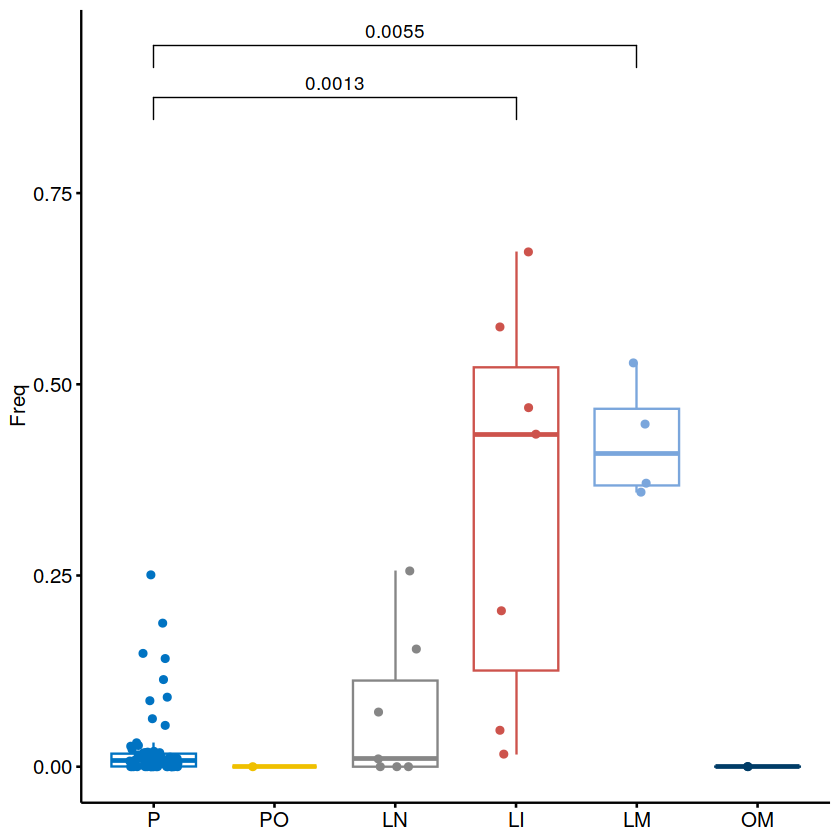

In [28]:
p_adj <- get_adj_p(data_plot_melt_C2,
                     .col = "Freq", .grp = "Tumors.for.scRNA.seq.short", p.adjust.method = "BH",
                     comparisons = list(c("P","PO"),c("P","LN"),c("P","LI"),c("P","LM"),c("P","OM")))
p <- ggboxplot(data_plot_melt_C2, x = "Tumors.for.scRNA.seq.short", y = "Freq", color = "Tumors.for.scRNA.seq.short", palette = "jco",add = "jitter") + 
    stat_pvalue_manual(p_adj, label = "p.adj", hide.ns = T)+
    theme(legend.position = "top") +
    theme(axis.title.x = element_blank(),
         legend.position = "none") 
p

In [137]:
pdf("./group_compare/F_C7_COL4A2_metastasis.location.pdf",width = 3,height = 3)
print(p)
dev.off()

png 
  2

## the relationship between proportion of endothelial cells and gene expression 

In [1439]:
data_plot = data.frame(expr = GetAssayData(Fibroblast_iCAFs,slot = "data")["C3",],ident = Fibroblast_iCAFs$NewSample.ID)

In [1440]:
attach(data_plot)
expr_mean = aggregate(data_plot, by = list(ident), FUN = mean)

The following object is masked from data_plot (pos = 4):

    expr


The following object is masked from data_plot (pos = 5):

    expr


The following object is masked from data_plot (pos = 6):

    expr


The following object is masked from data_plot (pos = 7):

    expr


The following object is masked from data_plot (pos = 8):

    expr


The following object is masked from data_plot (pos = 9):

    expr


The following object is masked from data_plot (pos = 10):

    expr


The following object is masked from data_plot (pos = 12):

    expr


The following object is masked from data_plot (pos = 13):

    expr


The following objects are masked from data_plot (pos = 14):

    expr, ident


The following objects are masked from data_plot (pos = 15):

    expr, ident


The following objects are masked from data_plot (pos = 16):

    expr, ident


The following objects are masked from data_plot (pos = 17):

    expr, ident


The following objects are masked from data_plot (pos = 18):


In [825]:
celltype_info = read.csv("/home/wyh/scdata/combined_data/meta_data/celltype_upload.txt",sep = "\t")

In [842]:
rownames(celltype_info) = celltype_info$name

In [838]:
orig.ident = lapply(celltype_info$name,
        FUN = function(i){
        data_split = unlist(strsplit(i,split = "_"))
        name = paste(data_split[1:(length(data_split)-1)],collapse = '_')
        #name = do.call(data_split[paste,args = data_split[1:(length(data_split)-1)]])
            return(name)
                          })
orig.ident = unlist(orig.ident)
celltype_info$orig.ident = orig.ident
celltype_info = as.data.frame(celltype_info)
celltype_info$barcode = celltype_info$name

In [846]:
celltype_info_immune = celltype_info[celltype_info$celltype!="Epithelial cells",]

In [848]:
ratio_all = as.data.frame.array(table(celltype_info_immune[,c("orig.ident","subtype")]))

In [851]:
ratio_all = ratio_all/rowSums(ratio_all)

In [996]:
iCAF_markers = Fibroblast_new2.markers[Fibroblast_new2.markers$cluster=="C1-CFD",]

In [1482]:
complement_KEGG = read.gmt("/home/wyh/database/msigdb/KEGG_COMPLEMENT_AND_COAGULATION_CASCADES.v2023.1.Hs.gmt")

Warning message in readLines(gmtfile):
“incomplete final line found on '/home/wyh/database/msigdb/KEGG_COMPLEMENT_AND_COAGULATION_CASCADES.v2023.1.Hs.gmt'”


In [1484]:
complement_hallmarks = read.gmt("/home/wyh/database/msigdb/HALLMARK_COMPLEMENT.v2023.1.Hs.gmt")

Warning message in readLines(gmtfile):
“incomplete final line found on '/home/wyh/database/msigdb/HALLMARK_COMPLEMENT.v2023.1.Hs.gmt'”


In [1485]:
Fibroblast_iCAFs = AddModuleScore(Fibroblast_iCAFs,features = list(KEGG = c(complement_KEGG$gene),hallmarks = complement_hallmarks$gene),name = "complement")

Warning message:
“The following features are not present in the object: SERPINE1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: CEBPB, CXCL1, HSPA1A, HSPA5, IL6, IRF1, MAFF, SERPINE1, TNFAIP3, not searching for symbol synonyms”


In [1446]:
library("plotrix")

In [1486]:
expr_mean_list = list()

In [1511]:
Clinical.stage = Fibroblast_iCAFs$Clinical.stage

In [1514]:
data_plot1 = data.frame(expr = GetAssayData(Fibroblast_iCAFs,slot = "data")["C3",])
expr_mean = aggregate(data_plot1, by = list(Clinical.stage), FUN = mean)
expr_se = aggregate(data_plot1, by = list(Clinical.stage), FUN = std.error)
expr_mean$se = expr_se$expr
rownames(expr_mean) = expr_mean$`Group.1`
expr_mean$mean = expr_mean$expr
expr_mean$group = "C3"
expr_mean$Clinical.stage = expr_mean$`Group.1`
head(expr_mean)
expr_mean_list[[1]] = expr_mean

,Group.1,expr,se,mean,group,Clinical.stage
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
I,I,2.965389,0.26728351,2.965389,C3,I
IIB,IIB,2.777070,0.55646346,2.777070,C3,IIB
IIIA,IIIA,3.500264,0.09814732,3.500264,C3,IIIA
IIIB,IIIB,3.376990,0.06967922,3.376990,C3,IIIB
IVA,IVA,3.189511,0.14954139,3.189511,C3,IVA
IVB,IVB,2.855229,0.05679599,2.855229,C3,IVB


In [1515]:
data_plot1 = data.frame(expr = GetAssayData(Fibroblast_iCAFs,slot = "data")["CXCL12",])
expr_mean = aggregate(data_plot1, by = list(Clinical.stage), FUN = mean)
expr_se = aggregate(data_plot1, by = list(Clinical.stage), FUN = std.error)
expr_mean$se = expr_se$expr
rownames(expr_mean) = expr_mean$`Group.1`
expr_mean$mean = expr_mean$expr
expr_mean$group = "CXCL12"
expr_mean$Clinical.stage = expr_mean$`Group.1`
head(expr_mean)
expr_mean_list[[2]] = expr_mean

,Group.1,expr,se,mean,group,Clinical.stage
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
I,I,1.487066,0.24448800,1.487066,CXCL12,I
IIB,IIB,2.119868,0.38650158,2.119868,CXCL12,IIB
IIIA,IIIA,2.125140,0.10912654,2.125140,CXCL12,IIIA
IIIB,IIIB,1.678185,0.05512369,1.678185,CXCL12,IIIB
IVA,IVA,1.595540,0.10839971,1.595540,CXCL12,IVA
IVB,IVB,1.481899,0.04331418,1.481899,CXCL12,IVB


In [1516]:
data_plot1 = data.frame(expr = GetAssayData(Fibroblast_iCAFs,slot = "data")["VEGFB",])
expr_mean = aggregate(data_plot1, by = list(Clinical.stage), FUN = mean)
expr_se = aggregate(data_plot1, by = list(Clinical.stage), FUN = std.error)
expr_mean$se = expr_se$expr
rownames(expr_mean) = expr_mean$`Group.1`
expr_mean$mean = expr_mean$expr
expr_mean$group = "VEGFB"
expr_mean$Clinical.stage = expr_mean$`Group.1`
head(expr_mean)
expr_mean_list[[3]] = expr_mean

,Group.1,expr,se,mean,group,Clinical.stage
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
I,I,1.3477766,0.25572914,1.3477766,VEGFB,I
IIB,IIB,1.2145548,0.32599396,1.2145548,VEGFB,IIB
IIIA,IIIA,0.6474047,0.07111329,0.6474047,VEGFB,IIIA
IIIB,IIIB,1.2948003,0.04865888,1.2948003,VEGFB,IIIB
IVA,IVA,1.3939614,0.08706542,1.3939614,VEGFB,IVA
IVB,IVB,1.2154186,0.03956221,1.2154186,VEGFB,IVB


In [1494]:
data_plot1 = data.frame(expr = Fibroblast_iCAFs$complement2)
expr_mean = aggregate(data_plot1, by = list(Clinical.stage), FUN = mean)
expr_se = aggregate(data_plot1, by = list(Clinical.stage), FUN = std.error)
expr_mean$se = expr_se$expr
rownames(expr_mean) = expr_mean$`Group.1`
expr_mean$mean = expr_mean$expr
expr_mean$group = "hallmarks_complement"
expr_mean$Clinical.stage = expr_mean$`Group.1`
head(expr_mean)
expr_mean_list[[5]] = expr_mean

,Group.1,expr,se,mean,group,Clinical.stage
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
I,I,0.1492142,0.008617089,0.1492142,hallmarks_complement,I
IIB,IIB,0.1563351,0.023111801,0.1563351,hallmarks_complement,IIB
IIIA,IIIA,0.1696217,0.003709209,0.1696217,hallmarks_complement,IIIA
IIIB,IIIB,0.1674165,0.002619912,0.1674165,hallmarks_complement,IIIB
IVA,IVA,0.1684194,0.001645365,0.1684194,hallmarks_complement,IVA
IVB,IVB,0.1475060,0.001002042,0.1475060,hallmarks_complement,IVB


In [1497]:
data_plot2 = data.frame(expr = GetAssayData(Fibroblast_iCAFs,slot = "data")["VEGFB",],complement = Fibroblast_iCAFs$complement2)

In [1498]:
cor.test(data_plot2$expr,data_plot2$complement)


	Pearson's product-moment correlation

data:  data_plot2$expr and data_plot2$complement
t = 4.7174, df = 3094, p-value = 2.494e-06
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.04942583 0.11937776
sample estimates:
       cor 
0.08450592 


In [1499]:
expr_mean_df = do.call(rbind,expr_mean_list)

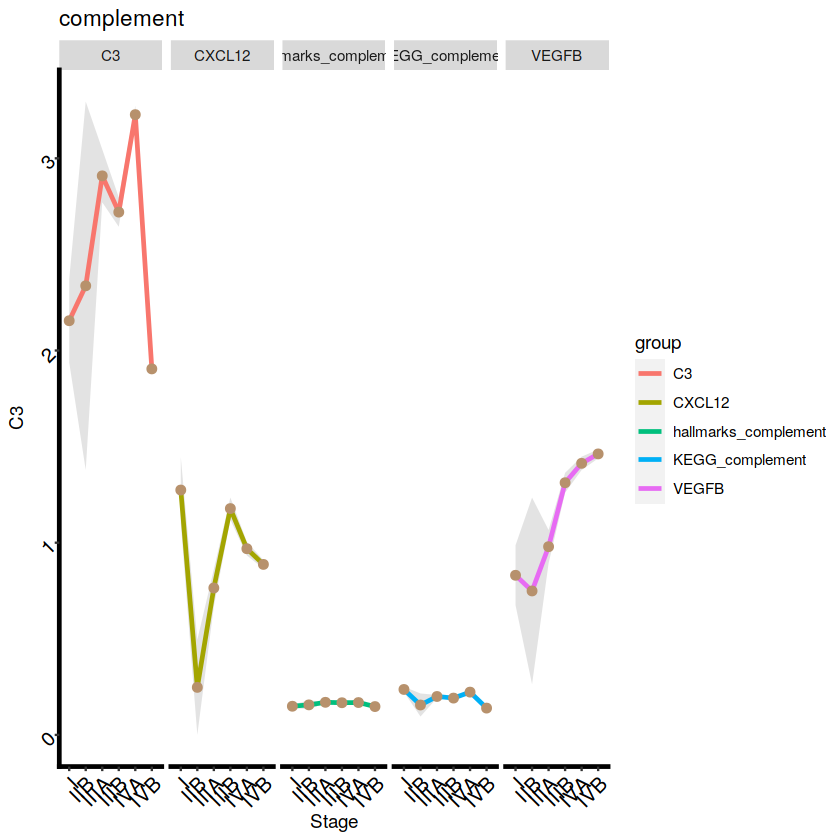

In [1500]:
ggplot(expr_mean_df,aes(Clinical.stage,mean,group = group))+
  geom_ribbon(aes(ymin=mean-se,ymax=mean+se),fill='#e3e3e3')+
  #geom_line(color=c('#B7916C'),size=1)+
  #geom_point(color='#B7916C',size=2)+
  geom_line(aes(color=group),size=1)+
  geom_point(color='#B7916C',size=2)+
  facet_grid(.~group)+
  theme(panel.background = element_blank(),
        panel.grid = element_line(color="white"),
        # axis.title = element_blank(),
        #axis.ticks = element_blank(),
        axis.text.x=element_text(colour='black',size=12,angle = 45,hjust = 1))+
  ggtitle('complement')+theme(axis.line=element_line(colour='black',size=1,lineend = 'square'))+
  theme (axis.text.x = element_text (colour='black', size=12, angle=45), 
         axis.text.y = element_text (colour='black',size=12, angle=45))+
  labs(x='Stage',y='C3')

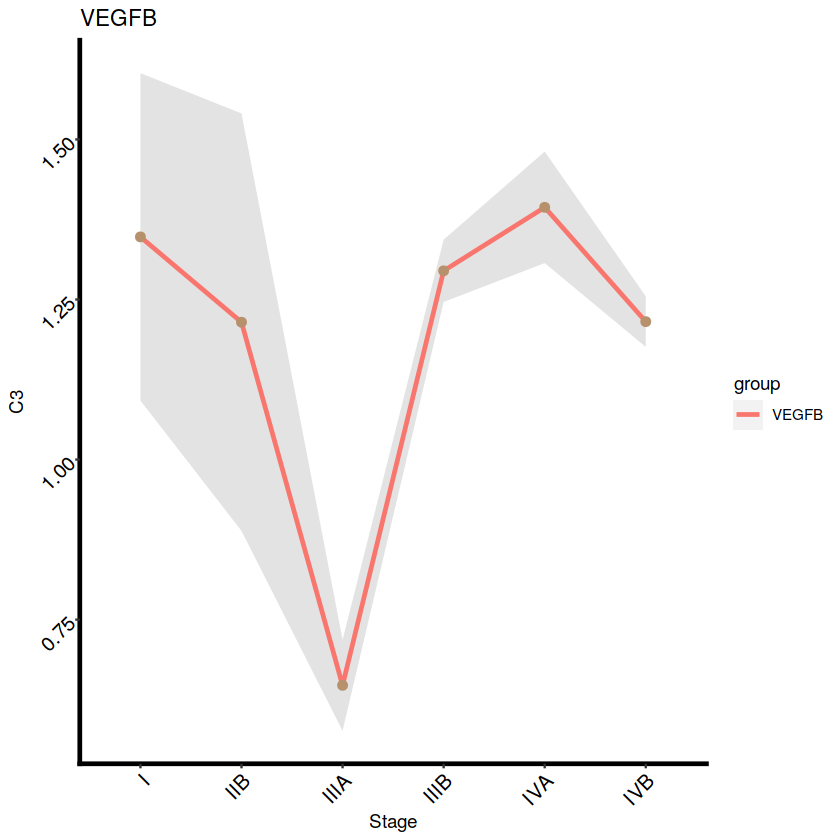

In [1518]:
ggplot(expr_mean_list[[3]],aes(Clinical.stage,mean,group = group))+
  geom_ribbon(aes(ymin=mean-se,ymax=mean+se),fill='#e3e3e3')+
  #geom_line(color=c('#B7916C'),size=1)+
  #geom_point(color='#B7916C',size=2)+
  geom_line(aes(color=group),size=1)+
  geom_point(color='#B7916C',size=2)+
  theme(panel.background = element_blank(),
        panel.grid = element_line(color="white"),
        # axis.title = element_blank(),
        #axis.ticks = element_blank(),
        axis.text.x=element_text(colour='black',size=12,angle = 45,hjust = 1))+
  ggtitle('VEGFB')+theme(axis.line=element_line(colour='black',size=1,lineend = 'square'))+
  theme (axis.text.x = element_text (colour='black', size=12, angle=45), 
         axis.text.y = element_text (colour='black',size=12, angle=45))+
  labs(x='Stage',y='C3')

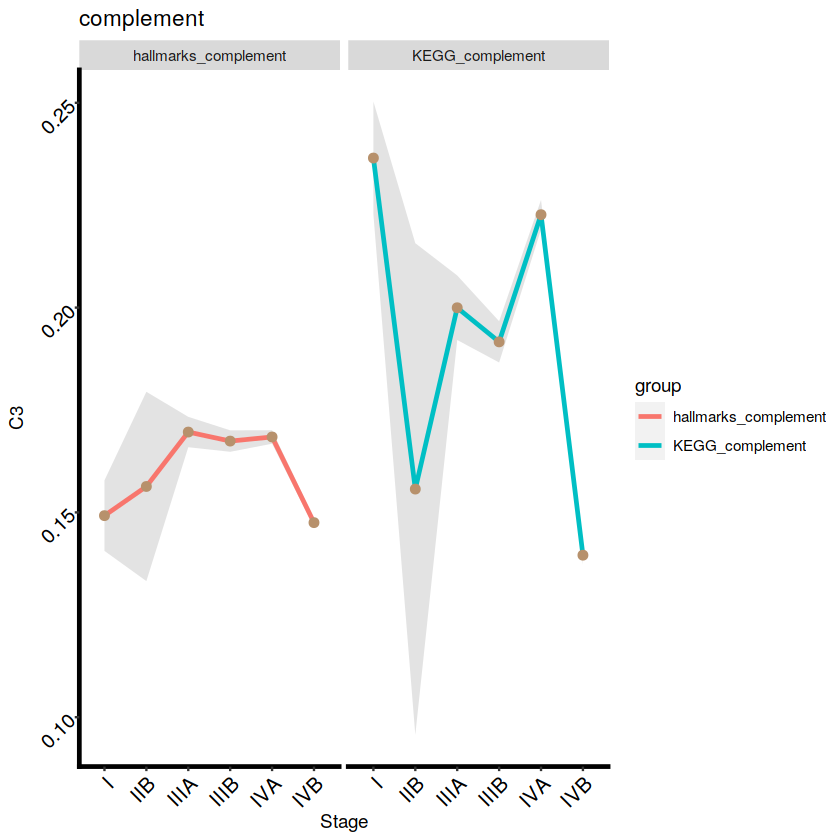

In [1501]:
ggplot(expr_mean_df[expr_mean_df$group %in% c("KEGG_complement",'hallmarks_complement'),],aes(Clinical.stage,mean,group = group))+
  geom_ribbon(aes(ymin=mean-se,ymax=mean+se),fill='#e3e3e3')+
  #geom_line(color=c('#B7916C'),size=1)+
  #geom_point(color='#B7916C',size=2)+
  geom_line(aes(color=group),size=1)+
  geom_point(color='#B7916C',size=2)+
  facet_grid(.~group)+
  theme(panel.background = element_blank(),
        panel.grid = element_line(color="white"),
        # axis.title = element_blank(),
        #axis.ticks = element_blank(),
        axis.text.x=element_text(colour='black',size=12,angle = 45,hjust = 1))+
  ggtitle('complement')+theme(axis.line=element_line(colour='black',size=1,lineend = 'square'))+
  theme (axis.text.x = element_text (colour='black', size=12, angle=45), 
         axis.text.y = element_text (colour='black',size=12, angle=45))+
  labs(x='Stage',y='C3')

In [1036]:
pdf("./figures/complement.pdf",width = 10,height = 3)
ggplot(expr_mean_df,aes(Clinical.stage,mean,group = group))+
  geom_ribbon(aes(ymin=mean-se,ymax=mean+se),fill='#e3e3e3')+
  #geom_line(color=c('#B7916C'),size=1)+
  #geom_point(color='#B7916C',size=2)+
  geom_line(aes(color=group),size=1)+
  geom_point(color='#B7916C',size=2)+
  facet_grid(.~group)+
  theme(panel.background = element_blank(),
        panel.grid = element_line(color="white"),
        # axis.title = element_blank(),
        #axis.ticks = element_blank(),
        axis.text.x=element_text(colour='black',size=12,angle = 45,hjust = 1))+
  ggtitle('complement')+theme(axis.line=element_line(colour='black',size=1,lineend = 'square'))+
  theme (axis.text.x = element_text (colour='black', size=12, angle=45), 
         axis.text.y = element_text (colour='black',size=12, angle=45))+
  labs(x='Stage',y='C3')
dev.off()

png 
  2

In [1037]:
pdf("./figures/complementV2.pdf",width = 6,height = 3)
ggplot(expr_mean_df[expr_mean_df$group %in% c("KEGG_complement",'hallmarks_complement'),],aes(Clinical.stage,mean,group = group))+
  geom_ribbon(aes(ymin=mean-se,ymax=mean+se),fill='#e3e3e3')+
  #geom_line(color=c('#B7916C'),size=1)+
  #geom_point(color='#B7916C',size=2)+
  geom_line(aes(color=group),size=1)+
  geom_point(color='#B7916C',size=2)+
  facet_grid(.~group)+
  theme(panel.background = element_blank(),
        panel.grid = element_line(color="white"),
        # axis.title = element_blank(),
        #axis.ticks = element_blank(),
        axis.text.x=element_text(colour='black',size=12,angle = 45,hjust = 1))+
  ggtitle('complement')+theme(axis.line=element_line(colour='black',size=1,lineend = 'square'))+
  theme (axis.text.x = element_text (colour='black', size=12, angle=45), 
         axis.text.y = element_text (colour='black',size=12, angle=45))+
  labs(x='Stage',y='C3')
dev.off()

png 
  2

## figureS7H difference between P_Mets and P

In [1099]:
Fibroblast_iCAFs$metastasis.type[Fibroblast_iCAFs$metastasis.type %in% c("P_LN","P_LM")] = "P_Metas"

In [1107]:
markers_P_metas = FindMarkers(Fibroblast_iCAFs,group.by = "metastasis.type",ident.1 = "P_Metas",ident.2 = "P",min.pct = 0.20)

In [1102]:
write.csv(markers_P_metas,"./group_compare/Fibroblast_iCAFs.markers.csv")

In [4]:
markers_P_metas = read.csv("./group_compare/Fibroblast_iCAFs.markers.csv",row.name = 1)

In [5]:
head(markers_P_metas)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AC005343.4,3.267587e-159,-0.4278258,0.000,0.168,1.043177e-154
C11orf96,2.479083e-29,1.2640175,0.837,0.751,7.914472e-25
GATD3A,6.824323e-28,-0.3342447,0.040,0.168,2.178665e-23
COL4A4,6.588656e-19,-0.5341989,0.153,0.327,2.103428e-14
MT1G,1.127850e-17,-0.7844910,0.045,0.147,3.600660e-13
CRLF1,3.358351e-17,-0.5753393,0.084,0.215,1.072154e-12


In [6]:
markers_P_metas$gene = rownames(markers_P_metas)

In [673]:
markers_P_metas_plot = markers_P_metas[markers_P_metas$gene!="AC005343.4",]
colnames(markers_P_metas_plot) = c("Pvalue","logFC","pct.1","pct.2","qvalue","gene")
pdf("/home/wyh/scdata/combined_data/fibroblast/submit/markers_P_metas_plot.pdf",height = 5,width = 4)
EnhancedVolcano::EnhancedVolcano(markers_P_metas_plot,
                title = "Differential expression", subtitle = "",
                selectLab = c("VEGFB",'HIF1A','CFD','CLU'),
                drawConnectors = TRUE, widthConnectors = 0.5, colConnectors = 'black', boxedLabels = TRUE,
                lab = markers_P_metas_plot$gene,
                col = c("grey30", "forestgreen", '#5956c8', '#dd3e34'),
                x = 'logFC',
                y = 'qvalue',
                xlim = c(-2, 2),
                FCcutoff = 0.25,
                pCutoff = 10e-2,
                legendLabSize = 10)+xlab(expression(paste("logFC",frac("P_Metas","P"))))
dev.off()

png 
  2

In [250]:
head(markers_P_metas)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
AC005343.4,3.267587e-159,-0.4278258,0.000,0.168,1.043177e-154,AC005343.4
C11orf96,2.479083e-29,1.2640175,0.837,0.751,7.914472e-25,C11orf96
GATD3A,6.824323e-28,-0.3342447,0.040,0.168,2.178665e-23,GATD3A
COL4A4,6.588656e-19,-0.5341989,0.153,0.327,2.103428e-14,COL4A4
MT1G,1.127850e-17,-0.7844910,0.045,0.147,3.600660e-13,MT1G
CRLF1,3.358351e-17,-0.5753393,0.084,0.215,1.072154e-12,CRLF1


In [7]:
markers_P_metas_plotV2 = markers_P_metas
markers_P_metas_plotV2 = markers_P_metas_plotV2[markers_P_metas_plotV2$gene!="AC005343.4",]

In [262]:
markers_P_metas_plotV2[order(-markers_P_metas_plotV2$avg_log2FC),]

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene,threshold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
C11orf96,2.479083e-29,1.2640175,0.837,0.751,7.914472e-25,C11orf96,UP
MT2A,4.815803e-11,0.9372720,0.915,0.869,1.537445e-06,MT2A,UP
AGT,2.903350e-08,0.8758205,0.262,0.136,9.268946e-04,AGT,UP
RGCC,7.125593e-08,0.8739314,0.225,0.110,2.274846e-03,RGCC,UP
GREM1,1.424433e-16,0.8410206,0.386,0.168,4.547502e-12,GREM1,UP
CHI3L1,2.459778e-03,0.8259243,0.125,0.073,1.000000e+00,CHI3L1,UP
SOD2,7.985230e-12,0.7617469,0.721,0.634,2.549285e-07,SOD2,UP
PTX3,2.311518e-02,0.7583088,0.119,0.084,1.000000e+00,PTX3,UP
MMP14,1.500640e-10,0.6755431,0.471,0.330,4.790795e-06,MMP14,UP


In [8]:
markers_P_metas_plotV2$threshold = "Non significant"
markers_P_metas_plotV2$threshold[markers_P_metas_plotV2$avg_log2FC>0] = "UP"
markers_P_metas_plotV2$threshold[markers_P_metas_plotV2$avg_log2FC<0] = 'DOWN'

In [266]:
markers_P_metas_plotV2$threshold = factor(markers_P_metas_plotV2$threshold,levels = c("UP",'DOWN',"Non significant"))

In [277]:
pdf("./submit/vocaloplot_P_P_metasV2.pdf",height = 3,width = 3)
library( ggrepel)
ggplot(markers_P_metas_plotV2,aes(x=avg_log2FC,y=-log10(p_val_adj),color=threshold))+
  geom_point()+
  scale_color_manual(values=c("#DC143C","#00008B","#808080"))+
  geom_text_repel(
    data = markers_P_metas_plotV2[markers_P_metas_plotV2$gene %in% c("VEGFB",'HIF1A'),],
    aes(label = gene),
    size = 3,
    segment.color = "black", show.legend = FALSE )+#添加关注的点的基因名
  theme_bw()+
  theme(
    legend.title = element_blank()
  )+
  ylab('-log10 (p-adj)')+
  xlab('log2 (FoldChange)')+
  geom_vline(xintercept=c(-1,1),lty=3,col="black",lwd=0.5) +
  geom_hline(yintercept = -log10(0.05),lty=3,col="black",lwd=0.5)+theme(legend.position="none")
  ggtitle("F_C1_CFD")
dev.off()

$title
[1] "F_C1_CFD"

attr(,"class")
[1] "labels"

png 
  2

### figureS7I enrichment analysis

In [9]:
library(clusterProfiler)



clusterProfiler v3.18.1  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter




In [10]:
UP_enrichGO_result = enrichGO(gene = markers_P_metas[markers_P_metas$avg_log2FC>0 & markers_P_metas$p_val_adj<0.05,]$gene,'org.Hs.eg.db', ont="BP", pvalueCutoff=0.01,keyType = "SYMBOL")

Loading required package: org.Hs.eg.db

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, ro

In [39]:
result = UP_enrichGO_result@result

In [37]:
result['GeneRatio'] = paste0("'",result[,'GeneRatio'])

In [40]:
write.csv(result,"./submit/iCAF_P_Metas_VS_P_UP_enrichGO_result.csv")

In [1157]:
pdf("/home/wyh/scdata/combined_data/fibroblast/submit/markers_P_metas_enrichedV3.pdf",height = 4,width =7)
dotplot(UP_enrichGO_result)
dev.off()

wrong orderBy parameter; set to default `orderBy = "x"`



png 
  2

## Figure S7F difference between normal and tumor

In [1128]:
Fibroblast_iCAFsV2 = Fibroblast_new2[,Fibroblast_new2$subtype3=="F_C1_CFD"]

In [1129]:
Fibroblast_iCAFsV2 = Fibroblast_iCAFsV2[,Fibroblast_iCAFsV2$histological.type.short %in% c("CC","XGC","LG","HG","adeno")]
# data_plot = fibroblast_ratio[,c(colnames(fibroblast_ratio)[1:cluster_num],"sample.type")]

In [1132]:
Fibroblast_iCAFsV2$sample.type = "Tumor"

Fibroblast_iCAFsV2$sample.type[Fibroblast_iCAFsV2$Tumors.for.scRNA.seq.short %in% c("CC","XGC")] = "Normal"
Fibroblast_iCAFsV2$sample.type[Fibroblast_iCAFsV2$histological.type.short %in% c("LG","HG")] = "Normal"

In [1133]:
markers_adeno_iCAF = FindMarkers(Fibroblast_iCAFsV2,group.by = "sample.type",ident.1 = "Tumor",ident.2 = "Normal",min.pct = 0.20)

In [1134]:
write.csv(markers_adeno_iCAF,"./group_compare/adeno_iCAF_markers.csv")

In [15]:
markers_adeno_iCAF = read.csv("./group_compare/adeno_iCAF_markers.csv",row.names = 1)

In [16]:
markers_adeno_iCAF$gene = rownames(markers_adeno_iCAF)

In [684]:
markers_adeno_iCAF_plot = markers_adeno_iCAF
colnames(markers_adeno_iCAF_plot) = c("Pvalue","logFC","pct.1","pct.2","qvalue","gene")
pdf("/home/wyh/scdata/combined_data/fibroblast/submit/markers_adeno_iCAF_plot.pdf",height = 7,width = 6)
EnhancedVolcano::EnhancedVolcano(markers_adeno_iCAF_plot,
                title = "Differential expression", subtitle = "",
                selectLab = c("COL10A1",'COL4A2','COL8A1','MMP11','COL5A2','COL12A1','COL18A1','MMP14','CFD','CLU'),
                drawConnectors = TRUE, widthConnectors = 0.5, colConnectors = 'black', boxedLabels = TRUE,
                lab = markers_adeno_iCAF_plot$gene,
                col = c("grey30", "forestgreen", '#5956c8', '#dd3e34'),
                x = 'logFC',
                y = 'qvalue',
                xlim = c(-2, 2),
                FCcutoff = 0.25,
                pCutoff = 10e-2,
                legendLabSize = 10)+xlab(expression(paste("logFC",frac("tumor","normal"))))
dev.off()

Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”


png 
  2

In [17]:
markers_adeno_iCAF_plot = markers_adeno_iCAF

In [18]:
markers_adeno_iCAF_plot$threshold = "Non significant"
markers_adeno_iCAF_plot$threshold[markers_adeno_iCAF_plot$avg_log2FC>0] = "UP"
markers_adeno_iCAF_plot$threshold[markers_adeno_iCAF_plot$avg_log2FC<0] = 'DOWN'

In [19]:
markers_adeno_iCAF_plot$threshold = factor(markers_adeno_iCAF_plot$threshold,levels = c("UP",'DOWN',"Non significant"))

In [278]:
pdf("./submit/vocaloplot_adeno_iCAF_plotV2.pdf",height = 3,width = 3)
library( ggrepel)
ggplot(markers_adeno_iCAF_plot,aes(x=avg_log2FC,y=-log10(p_val_adj),color=threshold))+
  geom_point()+
  scale_color_manual(values=c("#DC143C","#00008B","#808080"))+
  geom_text_repel(
    data = markers_adeno_iCAF_plot[markers_adeno_iCAF_plot$gene %in% c("COL10A1",'COL4A2','COL8A1','MMP11','COL5A2','COL12A1','COL18A1','MMP14'),],
    aes(label = gene),
    size = 3,
    segment.color = "black", show.legend = FALSE )+#添加关注的点的基因名
  theme_bw()+
  theme(
    legend.title = element_blank()
  )+
  ylab('-log10 (p-adj)')+
  xlab('log2 (FoldChange)')+
  geom_vline(xintercept=c(-1,1),lty=3,col="black",lwd=0.5) +
  geom_hline(yintercept = -log10(0.05),lty=3,col="black",lwd=0.5)+theme(legend.position="none")
  ggtitle("F_C1_CFD")
dev.off()

$title
[1] "F_C1_CFD"

attr(,"class")
[1] "labels"

png 
  2

### figureS7G enrichment analysis

In [20]:
UP_enrichGO_result_adeno = enrichGO(gene = markers_adeno_iCAF[markers_adeno_iCAF$avg_log2FC>0.25 & markers_adeno_iCAF$p_val_adj<0.05,]$gene,'org.Hs.eg.db', ont="BP", pvalueCutoff=0.01,keyType = "SYMBOL")

In [21]:
length(markers_adeno_iCAF[markers_adeno_iCAF$avg_log2FC>0.5 & markers_adeno_iCAF$p_val_adj<0.05,]$gene)

[1] 33

In [23]:
write.csv(UP_enrichGO_result_adeno@result,"./submit/iCAF_Tumor_VS_normal_UP_enrichGO_result.csv")

In [1140]:
pdf("/home/wyh/scdata/combined_data/fibroblast/submit/markers_adeno_iCAF_enrichedV2.pdf",height = 4,width =6)
dotplot(UP_enrichGO_result_adeno)   # 这个主要是说明
dev.off()

wrong orderBy parameter; set to default `orderBy = "x"`



png 
  2

# FigureS7C ratio comparison between normal and tumor

In [78]:
fibroblast_ratio = fibroblast_ratio_all[fibroblast_ratio_all$histological.type.short %in% c("CC","XGC","LG","HG","adeno"),]
data_plot = fibroblast_ratio[,c(colnames(fibroblast_ratio)[1:cluster_num],"sample.type")]
data_plot_melt = melt(data_plot)
colnames(data_plot_melt) = c("sample.type","variable","Freq")

Warning message in melt(data_plot):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_plot). In the next version, this warning will become an error.”
Using sample.type as id variables



In [80]:
data_plot_melt$Freq = data_plot_melt$Freq*100

In [30]:
pdf("./figures/tumor_normal_compare0810.pdf",height = 4,width = 3.5)
for(itype in high_entropy_cluster){
   p <- ggboxplot(data_plot_melt[data_plot_melt$variable==itype,], x = "sample.type", y = "Freq",
               color = "sample.type", palette = "jco",add = "jitter")
   print(p + stat_compare_means(label = "p.signif",comparisons = list(c("Normal","Tumor"))) +ggtitle(itype)+ylab("Percentage"))
}
dev.off()

png 
  2

In [85]:
high_entropy_cluster = c('F_C0_MMP11','F_C1_CFD','F_C2_COLEC11','Per_C0_RGS5','Per_C1_MYH11','Per_C3_STEAP4')

In [108]:
pdf("./figures/tumor_normal_compare0905.pdf",height = 4,width = 2)
for(itype in high_entropy_cluster){
   p <- ggboxplot(data_plot_melt[data_plot_melt$variable==itype,], x = "sample.type", y = "Freq",
               color = "sample.type", palette = "jco",add = "jitter")
   print(p + stat_compare_means(comparisons = list(c("Normal","Tumor"))) +ggtitle(itype)+ylab("Percentage"))+theme(axis.title.x = element_blank()) +
    theme(axis.text.x = element_blank())  
}
dev.off()

png 
  2

In [109]:
ggplot_list = list()
cluster_plot = c("F_C0_MMP11","Per_C0_RGS5","Per_C3_STEAP4")
for(itype in cluster_plot){
   p <- ggboxplot(data_plot_melt[data_plot_melt$variable==itype,], x = "sample.type", y = "Freq",
               color = "sample.type", palette = "jco",add = "jitter")
   ggplot_list[[itype]] = p + stat_compare_means(comparisons = list(c("Normal","Tumor")))+ylab(itype)+theme(axis.title.x = element_blank()) +
    theme(axis.text.x = element_blank())  
}


In [110]:
library("patchwork")
library(RColorBrewer)

In [111]:
pdf("./figures/tumor_normal_compare_combined.pdf",height = 3,width = 6)
ggplot_list[[1]]+ggplot_list[[2]]+ggplot_list[[3]] + plot_layout(guides = 'collect') & theme(legend.position = c("top"))
dev.off()

png 
  2

In [169]:
for(itype in high_entropy_cluster){
   pdf(paste0("./figures/normal_tumor_compare/",itype,".pdf"),height = 4,width = 3.5)
   p <- ggboxplot(data_plot_melt[data_plot_melt$variable==itype,], x = "sample.type", y = "Freq",
               color = "sample.type", palette = "jco",add = "jitter")
   print(p + stat_compare_means(label = "p.signif",comparisons = list(c("Normal","Tumor"))) +ggtitle(itype)+ylab("Percentage"))
   dev.off()
}


# figure S7D ratio comparison between P_metas and P

In [1245]:
fibroblast_ratio = fibroblast_ratio_all
fibroblast_ratio = fibroblast_ratio[fibroblast_ratio$Tumors.for.scRNA.seq.short=="P",]
fibroblast_ratio = fibroblast_ratio[fibroblast_ratio$histological.type.short %in% "adeno",]

In [1246]:
fibroblast_ratio$metastasis.type = as.character(fibroblast_ratio$metastasis.type)

In [1247]:
fibroblast_ratio$metastasis.type[fibroblast_ratio$metastasis.type %in% c("P_LN","P_LM")] = "P_Metas"

In [1248]:
data_plot = fibroblast_ratio[,c(colnames(fibroblast_ratio)[1:cluster_num],"metastasis.type")]
data_plot_melt = melt(data_plot)
colnames(data_plot_melt) = c("metastasis.type","variable","Freq")

Warning message in melt(data_plot):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_plot). In the next version, this warning will become an error.”
Using metastasis.type as id variables



In [119]:
ggplot_list = list()
cluster_plot = c("F_C1_CFD","Per_C1_MYH11","Per_C3_STEAP4")
for(itype in cluster_plot){
   p <- ggboxplot(data_plot_melt[data_plot_melt$variable==itype,], x = "metastasis.type", y = "Freq",
               color = "metastasis.type", palette = "jco",add = "jitter")
   ggplot_list[[itype]] = p + stat_compare_means(comparisons = list(c("P","P_Metas")))+ylab(itype)+theme(axis.title.x = element_blank()) +
    theme(axis.text.x = element_blank())  
}


In [120]:
library("patchwork")
library(RColorBrewer)

In [122]:
pdf("./figures/group_copare_metastasistype.pdf",height = 3,width = 6)
ggplot_list[[1]]+ggplot_list[[2]]+ggplot_list[[3]] + plot_layout(guides = 'collect') & theme(legend.position = c("top"))
dev.off()

png 
  2

In [63]:
pdf("./group_compare/group_compare_metastasistype.0816.pdf",width = 15,height = 5)
print(ggplot(data_plot_melt, aes( y=Freq, x=metastasis.type)) + geom_boxplot()+facet_grid(. ~variable)+
    theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1,color="black"),
         axis.text.y = element_text(color="black"),
         axis.title=element_text())+ggtitle("")+
           stat_compare_means(comparisons = list(
   c("P","P_Metas")
  ),method = "wilcox.test",label="p.signif"))
dev.off()

png 
  2

In [47]:
cluster_num = 16

In [245]:
data_plot = fibroblast_ratio[,c(colnames(fibroblast_ratio)[1:cluster_num],"metastasis.type")]
data_plot_melt = melt(data_plot)
colnames(data_plot_melt) = c("metastasis.type","variable","Freq")

pdf("/home/wyh/scdata/combined_data//fibroblast/group_compare/fibroblast_metastasis.type1129.pdf",width = 20,height = 10)
print(ggplot(data_plot_melt, aes( y=Freq, x=metastasis.type)) + geom_boxplot()+facet_grid(. ~variable)+
    theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1,color="black"),
         axis.text.y = element_text(color="black"),
         axis.title=element_text())+ggtitle("")+
           stat_compare_means(comparisons = list(
   c("P","P_LN"),c("P","P_LM"),c("P_LN","P_LM")
  ),method = "wilcox.test",label="p.signif"))
dev.off()

Warning message in melt(data_plot):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_plot). In the next version, this warning will become an error.”
Using metastasis.type as id variables

Warning message in wilcox.test.default(c(0.616541353383459, 0.392070484581498, 0.00583941605839416, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.616541353383459, 0.392070484581498, 0.00583941605839416, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0676691729323308, 0, 0, 0.0326209223847019, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0676691729323308, 0, 0, 0.0326209223847

png 
  2

In [34]:
data_plot = fibroblast_ratio[,c(colnames(fibroblast_ratio)[1:cluster_num],"metastasis.type")]
data_plot_melt = melt(data_plot)
colnames(data_plot_melt) = c("metastasis.type","variable","Freq")

pdf("/home/wyh/scdata/combined_data//fibroblast/group_compare/fibroblast_metastasis.type0810.pdf",width = 20,height = 10)
print(ggplot(data_plot_melt, aes( y=Freq, x=metastasis.type)) + geom_boxplot()+facet_grid(. ~variable)+
    theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1,color="black"),
         axis.text.y = element_text(color="black"),
         axis.title=element_text())+ggtitle("")+
           stat_compare_means(comparisons = list(
   c("P","P_LN"),c("P","P_LM"),c("P_LN","P_LM")
  ),method = "wilcox.test"))
dev.off()

Warning message in melt(data_plot):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_plot). In the next version, this warning will become an error.”
Using metastasis.type as id variables

Warning message in wilcox.test.default(c(0.616541353383459, 0.392070484581498, 0.00583941605839416, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.616541353383459, 0.392070484581498, 0.00583941605839416, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0676691729323308, 0, 0, 0.0326209223847019, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0676691729323308, 0, 0, 0.0326209223847

png 
  2

In [117]:
data_plot = fibroblast_ratio[,c(colnames(fibroblast_ratio)[1:cluster_num],"progression.type.short")]
data_plot_melt = melt(data_plot)
colnames(data_plot_melt) = c("progression.type.short","variable","Freq")

pdf("/home/wyh/scdata/combined_data//fibroblast/group_compare/fibroblast_progression.type.pdf",width = 20,height = 10)
print(ggplot(data_plot_melt, aes( y=Freq, x=progression.type.short)) + geom_boxplot()+facet_grid(. ~variable)+
    theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1,color="black"),
         axis.text.y = element_text(color="black"),
         axis.title=element_text())+ggtitle("")+
                  stat_compare_means(comparisons = list(
    c("Inflam","Proli"),c("Inflam","Mix"),c("Inflam","None"),
    c("Proli","Mix"),c("Proli","None")
  ),label="p.signif"))
dev.off()

Using progression.type.short as id variables

Warning message in wilcox.test.default(c(0.616541353383459, 0.422798552472859, 0.00803212851405622, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.616541353383459, 0.422798552472859, 0.00803212851405622, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.616541353383459, 0.422798552472859, 0.00803212851405622, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0145631067961165, 0.22020725388601, 0.479115479115479, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0145631067961165, 0.22020725388601, 0.479115479115479, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0676691729323308, 0.00422195416164053, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0676691729323308, 0.00422195416164053, :
“cannot compute exact p-value with

png 
  2

In [ ]:
 fibroblast_ratio = fibroblast_ratio_all[fibroblast_ratio_all$Tumors.for.scRNA.seq.short=="P",]
    fibroblast_ratio = fibroblast_ratio[fibroblast_ratio$histological.type.short %in% "adeno",]
    data_plot = fibroblast_ratio[,c(paste0("score_GM",1),"metastasis.type")]
    data_plot_melt = reshape2::melt(data_plot)
    colnames(data_plot_melt) = c("metastasis.type","variable","Freq")

    pdf(paste0("/home/wyh/scdata/combined_data//fibroblast/figures/adeno_epithelial_metastasis_icaf.pdf"),width = 30,height = 5)
    print(ggplot(data_plot_melt, aes( y=Freq, x=metastasis.type)) + geom_boxplot()+facet_grid(. ~variable)+
        theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1,color="black"),
             axis.text.y = element_text(color="black"),
             axis.title=element_text())+ggtitle("")+
          stat_compare_means(comparisons = list(
       c("P","P_LN"),c("P","P_LM"),c("P_LN","P_LM")
      ),method = "wilcox.test",label="p.signif"))
    dev.off()

In [35]:
data_plot = fibroblast_ratio[,c(colnames(fibroblast_ratio)[1:cluster_num],"metastasis.type")]
data_plot_melt = melt(data_plot)
colnames(data_plot_melt) = c("metastasis.type","variable","Freq")

Warning message in melt(data_plot):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_plot). In the next version, this warning will become an error.”
Using metastasis.type as id variables



In [36]:
data_plot_melt$Freq = data_plot_melt$Freq*100

In [174]:
for(itype in high_entropy_cluster){
   pdf(paste0("./figures/metastasis.type.compare/",itype,".pdf"),height = 4,width = 3.5)
   p <- ggboxplot(data_plot_melt[data_plot_melt$variable==itype,], x = "metastasis.type", y = "Freq",
               color = "metastasis.type", palette = "jco",add = "jitter")
   print(p + stat_compare_means(comparisons = list(
       c("P","P_LN"),c("P","P_LM"),c("P_LN","P_LM")
      ),method = "wilcox.test",label="p.signif")+ggtitle(itype)+ylab("Percentage"))
   dev.off()
}

Warning message in wilcox.test.default(c(0.616541353383459, 0.392070484581498, 0.00583941605839416, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.616541353383459, 0.392070484581498, 0.00583941605839416, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0676691729323308, 0, 0, 0.0326209223847019, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0676691729323308, 0, 0, 0.0326209223847019, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.179611650485437, 0.126943005181347, 0.0481927710843374, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0, 0.110132158590308, 0.0686131386861314, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.383495145631068, 0.194300518134715, 0.610441767068273, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.04

In [38]:
data_plot_melt$metastasis.type2 = as.character(data_plot_melt$metastasis.type)

In [39]:
data_plot_melt$metastasis.type2[data_plot_melt$metastasis.type2 %in% c("P_LN","P_LM")] = "P_Mets"

In [193]:
for(itype in high_entropy_cluster){
   pdf(paste0("./figures/metastasis.type.compare2/",itype,".pdf"),height = 4,width = 3.5)
   p <- ggboxplot(data_plot_melt[data_plot_melt$variable==itype,], x = "metastasis.type2", y = "Freq",
               color = "metastasis.type2", palette = "jco",add = "jitter")
   print(p + stat_compare_means(comparisons = list(
       c("P","P_Mets")
      ),method = "wilcox.test",label="p.signif")+ggtitle(itype)+ylab("Percentage"))
   dev.off()
}

In [41]:
for(itype in high_entropy_cluster){
   pdf(paste0("./figures/metastasis.type.compare2/",itype,"0810.pdf"),height = 4,width = 3.5)
   p <- ggboxplot(data_plot_melt[data_plot_melt$variable==itype,], x = "metastasis.type2", y = "Freq",
               color = "metastasis.type2", palette = "jco",add = "jitter")
   print(p + stat_compare_means(comparisons = list(
       c("P","P_Mets")
      ),method = "wilcox.test")+ggtitle(itype)+ylab("Percentage"))
   dev.off()
}

# survival 

In [1]:
library(dplyr)
library(survminer)
library(survival)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: ggpubr

Warning message:
“package ‘survival’ was built under R version 4.0.5”

Attaching package: ‘survival’


The following object is masked from ‘package:survminer’:

    myeloma




In [6]:
fibroblast_ratio_all = read.csv("./group_compare/fibroblast_ratio_all0816.csv",row.names = 1)

In [8]:
survival_info = read.csv("/home/wyh/scdata/patient_info/survival/survival_0916.csv",row.names = 1)
rownames(survival_info) = survival_info$NewSample.ID
head(survival_info)

,patient_index,DFS_month,OS_month,event,Sample.ID,NewSample.ID,Tumors.for.scRNA.seq,Sex,Age,TNM,⋯,T.stage,N.stage,M.stage,Liver.metastasis,liver.invasion,Lymph.node.metastasis,Peritoneal..metastasis,Bile.duct.invasion,Vascular.invasion,Tumor.location.in.GB
,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GBC_001_LI,237090,NA,6.0,dead,GBC1,GBC_001_LI,Liver invasion,M,67,T4NxM1,⋯,T4,Nx,M1,No,Yes,Yes,No,Yes,Yes,neck
GBC_002_P,365687,11.8,41.5,live,GBC2,GBC_002_P,Primary,F,85,T2bN0M0,⋯,T2b,N0,M0,No,No,No,No,No,No,fundus
GBC_003_P,365672,NA,5.0,dead,GBC3,GBC_003_P,Primary,F,71,T4NxM0,⋯,T4,Nx,M0,No,Yes,Yes,No,Yes,No,fundus
GBC_004_P,237543,11.6,41.1,live,GBC4,GBC_004_P,Primary,M,71,T3N1M1,⋯,T3,N1,M1,Yes,Yes,Yes,No,No,No,fundus-body
GBC_005_P,237456,1.6,3.5,dead,GBC5,GBC_005_P,Primary,M,68,T4NxM0,⋯,T4,Nx,M0,No,Yes,Yes,No,No,No,fundus-body
GBC_006_P,365681,NA,8.4,dead,GBC6,GBC_006_P,Primary,M,59,T4N1M0,⋯,T4,N1,M0,No,Yes,Yes,No,Yes,No,body-neck


In [9]:
#
fibroblast_ratio = fibroblast_ratio_all
fibroblast_ratio = fibroblast_ratio[fibroblast_ratio$Tumors.for.scRNA.seq.short=="P",]
fibroblast_ratio = fibroblast_ratio[fibroblast_ratio$histological.type.short %in% "adeno",]


common_patient = intersect(rownames(fibroblast_ratio),rownames(survival_info))
fibroblast_ratio = left_join(fibroblast_ratio[common_patient,],survival_info[common_patient,],by = "NewSample.ID")
rownames(fibroblast_ratio) = fibroblast_ratio$NewSample.ID
fibroblast_ratio$event01 = ifelse(fibroblast_ratio$event=="dead",1,0)
head(fibroblast_ratio)

,F_C0_MMP11,F_C1_CFD,F_C10_ACTG2,F_C11_APOD,F_C2_COLEC11,F_C3_IGFBP2,F_C4_CCN5,F_C5_KRT19,F_C6_MMP1,F_C7_COL4A2,⋯,N.stage.y,M.stage.y,Liver.metastasis.y,liver.invasion.y,Lymph.node.metastasis.y,Peritoneal..metastasis.y,Bile.duct.invasion.y,Vascular.invasion.y,Tumor.location.in.GB.y,event01
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
GBC_002_P,0.616541353,0.067669173,0.000000000,0,0.000000000,0.007518797,0,0.000000000,0.011278195,0.003759398,⋯,N0,M0,No,No,No,No,No,No,fundus,0
GBC_003_P,0.014563107,0.179611650,0.009708738,0,0.383495146,0.000000000,0,0.004854369,0.000000000,0.014563107,⋯,Nx,M0,No,Yes,Yes,No,Yes,No,fundus,1
GBC_004_P,0.422798552,0.004221954,0.045838359,0,0.005428227,0.005428227,0,0.001809409,0.001809409,0.004221954,⋯,N1,M1,Yes,Yes,Yes,No,No,No,fundus-body,0
GBC_006_P,0.220207254,0.126943005,0.002590674,0,0.194300518,0.010362694,0,0.005181347,0.010362694,0.012953368,⋯,N1,M0,No,Yes,Yes,No,Yes,No,body-neck,1
GBC_007_P,0.008032129,0.048192771,0.000000000,0,0.610441767,0.000000000,0,0.000000000,0.000000000,0.000000000,⋯,Nx,M1,No,Yes,Yes,No,Yes,Yes,neck,1
GBC_008_P,0.392070485,0.000000000,0.004405286,0,0.110132159,0.008810573,0,0.008810573,0.000000000,0.008810573,⋯,N0,M0,No,No,No,No,No,No,body,0


In [ ]:
## 单个分组的预后

In [10]:
itype = "F_C1_CFD"
fibroblast_ratio[paste0("Score")] = ifelse(fibroblast_ratio[itype] > median(fibroblast_ratio[,itype]),'High','Low')

In [11]:
fit<-survfit(Surv(OS_month, event01)~Score, data=fibroblast_ratio)
 

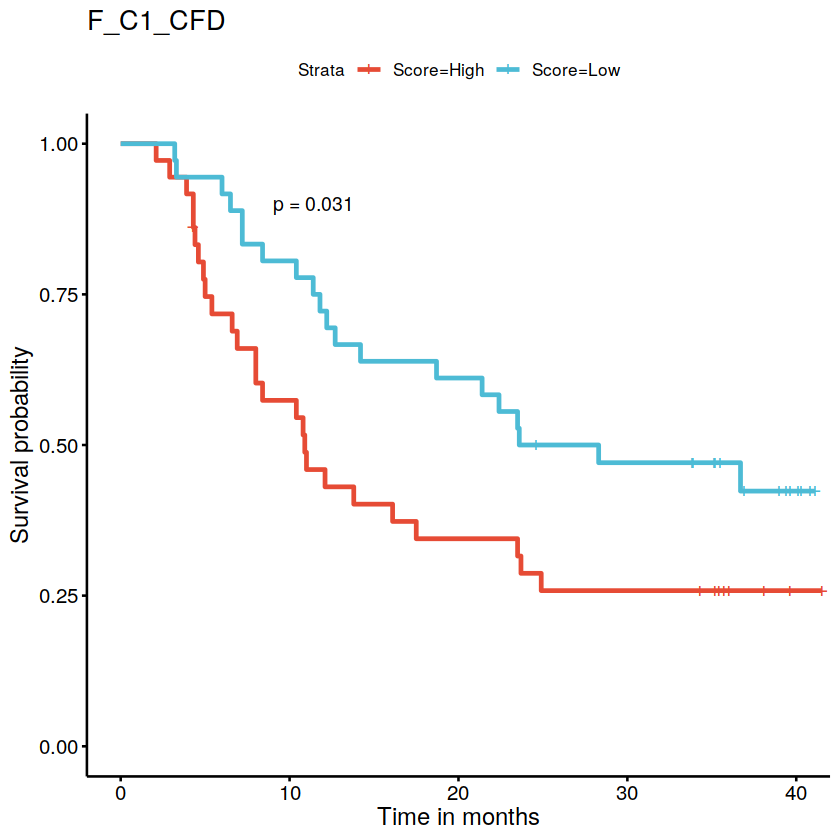

In [12]:
p = ggsurvplot(
    fit,                     # survfit object with calculated statistics.
    data = fibroblast_ratio,             # data used to fit survival curves.
    #risk.table = TRUE,       # show risk table.
    pval = TRUE,             # show p-value of log-rank test.
    #conf.int = TRUE,         # show confidence intervals for
    palette = "npg",
    xlab = "Time in months",   # customize X axis label.
    #ggtheme = theme_bw(),
    #conf.int.style = "step",  # customize style of confidence intervals  "ribbon" 'step'
    #surv.median.line = "hv",  # add the median survival pointer.
    # legend.labs = c("TP1", "TP2","TP3","TP4","TP5")    # change legend labels.
    tables.y.text = T,
    risk.table.pos = "in",
    risk.table.col = "strata",
    fontsize = 4,
    pval.size = 4,
    #surv.plot.height = 0.8,
    #tables.height = 0.2,
    pval.coord = c(9, 0.9),
    legend = "top",
    title = "F_C1_CFD"
  )
p

In [45]:
pdf("./figures/F_C1_CFD_survivalV3.pdf",height = 3.5,width = 3.5)
print(p,newpage = FALSE)
dev.off()

png 
  2